## ABC-SMC: model comparison

## User defined parameters (abundance-type and data-type)

SET THIS PARAMETERS BEFORE RUNNING

In [1]:
abundance = 'relative'#'absolute'
dataset = 'logistic'#'LV'

In [2]:
print('%s dataset'%dataset)
print('%s abundance'%abundance)

logistic dataset
relative abundance


## Hide or show code

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle on/off the raw code."></form>''')

## Import packages

In [4]:
%matplotlib inline

import matplotlib.pyplot as mp
import numpy as np
import scipy as sp
import pickle as pc

from random import random
from datetime import timedelta

from pyabc import ABCSMC, RV, Distribution, MultivariateNormalTransition, QuantileEpsilon, ModelPerturbationKernel, ListEpsilon
from pyabc.populationstrategy import AdaptivePopulationSize, ListPopulationSize
from pyabc.visualization import plot_kde_matrix
from pyabc.sampler import SingleCoreSampler

import matplotlib.lines as mlines

from matplotlib import rc
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
mp.rcParams['figure.figsize'] = (4, 4)

# import warnings
# warnings.filterwarnings('ignore')

## Import models and set storing location for results

In [5]:
if abundance == 'absolute':
    from sc_logistic_numerics import model_abs_abund_closure_from_3rd as logistic_model_abund
    from sc_LV_numerics import model_abs_abund_closure_from_3rd as LV_model_abund 
    
    logistic_db_path_abund = "sqlite:///../data/model_comparison/logistic_simulation_abs_abund.db"
    LV_db_path_abund = "sqlite:///../data/model_comparison/LV_simulation_abs_abund.db"

if abundance == 'relative':
    from sc_logistic_numerics import model_rel_abund_closure_from_3rd as logistic_model_abund
    from sc_LV_numerics import model_rel_abund_closure_from_3rd as LV_model_abund

    logistic_db_path_abund = "sqlite:///../data/model_comparison/logistic_simulation_rel_abund.db"
    LV_db_path_abund = "sqlite:///../data/model_comparison/LV_simulation_rel_abund.db"

## Import dataset

In [6]:
if abundance == 'absolute': abund_type = 'abs_abund'
elif abundance == 'relative': abund_type = 'rel_abund'

if dataset == 'logistic':

    with open('../data/logistic/simulation_%s.pickle'%abund_type, 'rb') as f: 
        logistic_sim_abund = pc.load(f)
    logistic_data_abund = logistic_sim_abund['data']
    logistic_numerics_abund = logistic_sim_abund['numerics']

    with open('../data/logistic/simulation_parameters.pickle', 'rb') as f: 
        logistic_sim_par = pc.load(f)
    n_types = logistic_sim_par['n_types']
    true_par = logistic_sim_par['true_par']
    gR = logistic_sim_par['gR']
    dR = logistic_sim_par['dR']
    mR = logistic_sim_par['mR']
    
if dataset == 'LV':

    with open('../data/LV/simulation_%s.pickle'%abund_type, 'rb') as f: 
        LV_sim_abund = pc.load(f)
    LV_data_abund = LV_sim_abund['data']
    LV_numerics_abund = LV_sim_abund['numerics']

    with open('../data/LV/simulation_parameters.pickle', 'rb') as f: 
        LV_sim_par = pc.load(f)
    n_types = LV_sim_par['n_types']
    true_par = LV_sim_par['true_par']
    gR = LV_sim_par['gR']

## Define a "distance" metric

In [7]:
def distance_abs_abund(predicted_moments_abs_abund, empirical_moments_abs_abund):
    
    empirical_data = empirical_moments_abs_abund["moments"]
    predicted_data = predicted_moments_abs_abund["moments"]

    # Compute the distance metric
    criteria = np.sqrt(((empirical_data - predicted_data)**2).sum())
        
    return criteria

def distance_rel_abund(predicted_moments_rel_abund, empirical_moments_rel_abund):
    
    empirical_data = empirical_moments_rel_abund["moments"]
    predicted_data = predicted_moments_rel_abund["moments"][:,:-1]
    
    # Compute the distance metric
    criteria = np.sqrt(((empirical_data - predicted_data)**2).sum())
        
    return criteria

if abundance == 'absolute': distance_abund = distance_abs_abund
elif abundance == 'relative': distance_abund = distance_rel_abund

## Inference

Define the priors

In [8]:
# For logistic growth, death and migration model

gR_names = ["gR_%i"%i for i in range(n_types)]
dR_names = ["dR_%i"%i for i in range(n_types)]
mR_names = ["mR_%i"%i for i in range(n_types)]
N_names = ["N"]
mSigma_names = ["mSigma[0]"]

# Growth rates
gR_prior = n_types * [("uniform", 0, 2)]
# Death rates
dR_prior = n_types * [("uniform", 0, 2E2)]
# Immigration rates
mR_prior = n_types * [("norm", 3E3, 1E3)]
# Carrrying capacity
N_prior = [("norm", 1E5, 1E4)]
# Scaling factor
mSigma_prior = [("uniform", 4E3, 2E3)]

logistic_parameter_names = gR_names + dR_names + mR_names + N_names + mSigma_names
logistic_priors_shapes = gR_prior + dR_prior + mR_prior + N_prior + mSigma_prior
logistic_priors_dict = dict(zip(logistic_parameter_names, logistic_priors_shapes))

logistic_priors = Distribution(**{key: RV(a, b, c) for key, (a, b, c) in logistic_priors_dict.items()})

print('Logistic model priors:', '\n', logistic_priors_dict)

Logistic model priors: 
 {'gR_0': ('uniform', 0, 2), 'gR_1': ('uniform', 0, 2), 'gR_2': ('uniform', 0, 2), 'dR_0': ('uniform', 0, 200.0), 'dR_1': ('uniform', 0, 200.0), 'dR_2': ('uniform', 0, 200.0), 'mR_0': ('norm', 3000.0, 1000.0), 'mR_1': ('norm', 3000.0, 1000.0), 'mR_2': ('norm', 3000.0, 1000.0), 'N': ('norm', 100000.0, 10000.0), 'mSigma[0]': ('uniform', 4000.0, 2000.0)}


In [9]:
# For Lotka-Volterra model

gR_names = ["gR_%i"%i for i in range(n_types)]
I_intra_names, I_inter_names = [], []
for i in range(n_types):
    for j in range(n_types):
        if i == j: I_intra_names.append("I_%i_%i"%(i,j))
        else: I_inter_names.append("I_%i_%i"%(i,j))
mSigma_names = ["mSigma[0]"]

# Growth rates
gR_prior = n_types * [("norm", 1.5, 5E-1)]
# Intra-specific interactions
I_intra_prior = n_types * [("uniform", -1E-4, 1E-4)]
# Inter-specific interactions
I_inter_prior = (n_types**2-n_types) * [("norm", 0, 5E-5)]
# Scaling factor
mSigma_prior = [("uniform", 1.5E4, 1E4)]

LV_parameter_names = gR_names + I_intra_names + I_inter_names + mSigma_names
LV_priors_shapes = gR_prior + I_intra_prior + I_inter_prior + mSigma_prior
LV_priors_dict = dict(zip(LV_parameter_names, LV_priors_shapes))

LV_priors = Distribution(**{key: RV(a, b, c) for key, (a, b, c) in LV_priors_dict.items()})

print('LV model priors:', '\n', LV_priors_dict)

LV model priors: 
 {'gR_0': ('norm', 1.5, 0.5), 'gR_1': ('norm', 1.5, 0.5), 'gR_2': ('norm', 1.5, 0.5), 'I_0_0': ('uniform', -0.0001, 0.0001), 'I_1_1': ('uniform', -0.0001, 0.0001), 'I_2_2': ('uniform', -0.0001, 0.0001), 'I_0_1': ('norm', 0, 5e-05), 'I_0_2': ('norm', 0, 5e-05), 'I_1_0': ('norm', 0, 5e-05), 'I_1_2': ('norm', 0, 5e-05), 'I_2_0': ('norm', 0, 5e-05), 'I_2_1': ('norm', 0, 5e-05), 'mSigma[0]': ('uniform', 15000.0, 10000.0)}


Define the prior to bias/unbias model selection

In [10]:
# Unbiased prior
model_priors = RV("binom", 1, 0.5)

print('unbiased prior')

unbiased prior


"Distance" for true parameters

In [11]:
if dataset == 'logistic':

    true_par_error_abund = distance_abund(logistic_numerics_abund, logistic_data_abund)

if dataset == 'LV':
    
    true_par_error_abund = distance_abund(LV_numerics_abund, LV_data_abund)

print('eps with true parameters (abs. abund.): %.4e'%true_par_error_abund)

eps with true parameters (abs. abund.): 3.0946e-02


Define settings for inference

In [12]:
# Settings for inference

### For ABCSMC function

## For population size

# Number of samples in the first generation
start_nr_particles_p = 750

# CV criterion (smaller values lead to more samples per generation)
mean_cv_p = 0.4

# Number of samples to estimate the eps in first generation
nr_calibration_particles_p = 2000

# Number of bootstrapped samples to estimate the CV of a generation
n_bootstrap_p = 2

# Minimum number of samples allowed in a generation
min_population_size_p = 500

# Maximum number of samples allowed in a generation
max_population_size_p = 1000

## For transitions

# Factor to multiply the covariance with
scaling_p = 1.

## For eps

# Initial eps (if ='from sample', eps will be calculated from the prior)
initial_epsilon_p = 'from_sample'

# Quantile for cut-off of samples within a generation (e.g. 0.1 means top 10%)
alpha_p = 0.1

# Factor to multiply the quantile with
quantile_multiplier_p = 1.

### For running ABCSMC function

## Stopping criterion: minimum eps
minimum_epsilon_abund_p = 1.5 * true_par_error_abund

## Stopping criterion: maximum number of generations
max_nr_populations_p = 30

## Stopping criterion: maximum computing time
max_walltime_p = timedelta(minutes=480)

Save settings for inference

In [13]:
if abundance == 'absolute': min_eps_abund_name = 'minimum_epsilon_abs_abund_p'
elif abundance == 'relative': min_eps_abund_name = 'minimum_epsilon_rel_abund_p'

if dataset == 'logistic':
    
    with open('../data/model_comparison/logistic_simulation_inference_parameters.pickle', 'wb') as f:
        inference_dict = {'priors_dict': logistic_priors_dict, 'start_nr_particles_p': start_nr_particles_p, 'mean_cv_p': mean_cv_p, 'nr_calibration_particles_p': nr_calibration_particles_p, 'n_bootstrap_p': n_bootstrap_p, 'min_population_size_p': min_population_size_p, 'max_population_size_p': max_population_size_p, 'scaling_p': scaling_p, 'initial_epsilon_p': initial_epsilon_p, 'alpha_p': alpha_p, 'quantile_multiplier_p': quantile_multiplier_p, min_eps_abund_name: minimum_epsilon_abund_p, 'max_nr_populations_p': max_nr_populations_p, 'max_walltime_p': max_walltime_p}
        pc.dump(inference_dict, f)

if dataset == 'LV':

    with open('../data/model_comparison/LV_simulation_inference_parameters.pickle', 'wb') as f:
        inference_dict = {'priors_dict': LV_priors_dict, 'start_nr_particles_p': start_nr_particles_p, 'mean_cv_p': mean_cv_p, 'nr_calibration_particles_p': nr_calibration_particles_p, 'n_bootstrap_p': n_bootstrap_p, 'min_population_size_p': min_population_size_p, 'max_population_size_p': max_population_size_p, 'scaling_p': scaling_p, 'initial_epsilon_p': initial_epsilon_p, 'alpha_p': alpha_p, 'quantile_multiplier_p': quantile_multiplier_p, min_eps_abund_name: minimum_epsilon_abund_p, 'max_nr_populations_p': max_nr_populations_p, 'max_walltime_p': max_walltime_p}
        pc.dump(inference_dict, f)
        
print(inference_dict)

{'priors_dict': {'gR_0': ('uniform', 0, 2), 'gR_1': ('uniform', 0, 2), 'gR_2': ('uniform', 0, 2), 'dR_0': ('uniform', 0, 200.0), 'dR_1': ('uniform', 0, 200.0), 'dR_2': ('uniform', 0, 200.0), 'mR_0': ('norm', 3000.0, 1000.0), 'mR_1': ('norm', 3000.0, 1000.0), 'mR_2': ('norm', 3000.0, 1000.0), 'N': ('norm', 100000.0, 10000.0), 'mSigma[0]': ('uniform', 4000.0, 2000.0)}, 'start_nr_particles_p': 750, 'mean_cv_p': 0.4, 'nr_calibration_particles_p': 2000, 'n_bootstrap_p': 2, 'min_population_size_p': 500, 'max_population_size_p': 1000, 'scaling_p': 1.0, 'initial_epsilon_p': 'from_sample', 'alpha_p': 0.1, 'quantile_multiplier_p': 1.0, 'minimum_epsilon_rel_abund_p': 0.04641830945134077, 'max_nr_populations_p': 30, 'max_walltime_p': datetime.timedelta(seconds=28800)}


### Inference with the correct model to get an eps ("model error") reduction schedule

With simulated data, this step precedes model comparison to find an initial eps ("model error") and reduction schedule. The logic is that models will be considered good only if they achieve similar eps reduction as the correct model.
This approach prevents the model comparison from getting stuck at poor eps levels tricked by models that overwhelmingly decrease eps early-on (eg. a Lotka-Volterra model on a logistic dataset) but fall short decreasing to lower eps possible.

With empirical datasets this approach can be substitued by requesting lower and lower eps ("model error"), of course without going to far to avoid overfitting. Better models will succeed in achiving lower eps.

In [14]:
if dataset == 'logistic':

    # Create ABC-SMC function
    
    abc_abund_logistic = ABCSMC(
        models=logistic_model_abund,
        parameter_priors=logistic_priors,
        distance_function=distance_abund,
        population_size=AdaptivePopulationSize(start_nr_particles=start_nr_particles_p, mean_cv = mean_cv_p, nr_calibration_particles=nr_calibration_particles_p, n_bootstrap=n_bootstrap_p, min_population_size = min_population_size_p, max_population_size = max_population_size_p),   
        transitions=MultivariateNormalTransition(scaling=scaling_p),
        eps=QuantileEpsilon(initial_epsilon=initial_epsilon_p, alpha=alpha_p, quantile_multiplier=quantile_multiplier_p),
    )

    # Load data
    
    abc_abund_logistic.new(logistic_db_path_abund, {"moments": logistic_data_abund["moments"]});

    # Run ABC-SMC function
    
    history_abund_logistic = abc_abund_logistic.run(minimum_epsilon = minimum_epsilon_abund_p, max_nr_populations = max_nr_populations_p, max_walltime = max_walltime_p)
    print('total number of simulations: %i'%history_abund_logistic.total_nr_simulations)

    # Save vector of eps reduction
    
    eps_p = list(history_abund_logistic.get_all_populations().loc[:,'epsilon'][1:])

ABC.Sampler INFO: Parallelize sampling on 24 processes.
ABC.History INFO: Start <ABCSMC id=3, start_time=2023-07-02 21:26:43>
ABC INFO: Calibration sample t = -1.
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in

/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:90: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * dR * (m_k * m_Sigma - 2. * m_kk * m_Sigma**2) / N
/home/zapien/microbiome_fitting/logistic_numerics.py:89: Runt

/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag

/home/zapien/microbiome_fitting/logistic_numerics.py:90: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * dR * (m_k * m_Sigma - 2. * m_kk * m_Sigma**2) / N
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:90: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * dR * (m_k * m_Sigma - 2. * m_kk * m_Sigma**2) / N
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true

/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:83: RuntimeWarning: invalid value encountered in subtract
  D_m_k -= m_k * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:83: RuntimeWarning: invalid value encountered in subtract
  D_m_k -= m_k * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:83: RuntimeWarning: invalid value encountered in subtract
  D_m_k -= m_k * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk 

/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:83: RuntimeWarning: invalid value encountered in subtract
  D_m_k -= m_k * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py

/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:90: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * dR * (m_k * m_Sigma - 2. * m_kk * m_Sigma

/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:90: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * dR * (m_k * m_Sigma - 2. * m_kk * m_Sigma**2) / N
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:108: Runti

/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/za

/home/zapien/microbiome_fitting/logistic_numerics.py:83: RuntimeWarning: invalid value encountered in subtract
  D_m_k -= m_k * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/

/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fi

/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitting/logi

/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitting/logi

/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:83: RuntimeWarning: invalid value encountered in subtract
  D_m_k -= m_k * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitti

/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:90: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * dR * (m_k * m_Sigma - 2. * m_kk * m_Sigma**2) / N
/home/zapien/microbiome_

/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:83: RuntimeWarning: invalid value encountered in subtract
  D_m_k -= m_k * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py

/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:90: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * dR * (m_k * m_Sigma - 2. * m_kk * m_Sigma**2) / N
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:109: Run

/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encount

/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:90: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * dR * (m_k * m_Sigma - 2. * m_kk * m_Sigma**2) / N
/home/zapien/microbiome_

/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:90: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * dR * (m_k * m_Sigma - 2. * m_kk * m_Sigma**2) / N
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:109: Run

/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encount

total number of simulations: 38610


In [15]:
if dataset == 'LV':

    # Create ABC-SMC function
    
    abc_abund_LV = ABCSMC(
        models=LV_model_abund,
        parameter_priors=LV_priors,
        distance_function=distance_abund,
        population_size=AdaptivePopulationSize(start_nr_particles=start_nr_particles_p, mean_cv = mean_cv_p, nr_calibration_particles=nr_calibration_particles_p, n_bootstrap=n_bootstrap_p, min_population_size = min_population_size_p, max_population_size = max_population_size_p),   
        transitions=MultivariateNormalTransition(scaling=scaling_p),
        eps=QuantileEpsilon(initial_epsilon=initial_epsilon_p, alpha=alpha_p, quantile_multiplier=quantile_multiplier_p),
    )

    # Load data
    
    abc_abund_LV.new(LV_db_path_abund, {"moments": LV_data_abund["moments"]});

    # Run ABC-SMC function
    
    history_abund_LV = abc_abund_LV.run(minimum_epsilon = minimum_epsilon_abund_p, max_nr_populations = max_nr_populations_p, max_walltime = max_walltime_p)
    print('total number of simulations: %i'%history_abund_LV.total_nr_simulations)

    # Save vector of eps reduction
    
    eps_p = list(history_abund_LV.get_all_populations().loc[:,'epsilon'][1:])

### Model comparison

Create ABC-SMC function for model comparison (consult pyABC documentation for details)

In [16]:
abc_abund = ABCSMC(
    models=[logistic_model_abund, LV_model_abund],
    parameter_priors=[logistic_priors, LV_priors],
    distance_function=distance_abund,
    population_size=ListPopulationSize(nr_calibration_particles=nr_calibration_particles_p, values = len(eps_p)*[2000]),
    transitions=[MultivariateNormalTransition(scaling=scaling_p), MultivariateNormalTransition(scaling=scaling_p)],
    eps=ListEpsilon(eps_p),
    model_perturbation_kernel=ModelPerturbationKernel(nr_of_models=2,probability_to_stay=0.5),
    stop_if_only_single_model_alive=True,
    model_prior=model_priors,
)

ABC.Sampler INFO: Parallelize sampling on 24 processes.


Load data and run ABC-SMC function

In [17]:
if dataset == 'logistic':

    abc_abund.new(logistic_db_path_abund, {"moments": logistic_data_abund["moments"]});

if dataset == 'LV':

    abc_abund.new(LV_db_path_abund, {"moments": LV_data_abund["moments"]});

history_abund = abc_abund.run(minimum_epsilon = minimum_epsilon_abund_p, max_nr_populations = max_nr_populations_p, max_walltime = max_walltime_p)
print('total number of simulations: %i'%history_abund.total_nr_simulations)

ABC.History INFO: Start <ABCSMC id=4, start_time=2023-07-02 21:38:12>
ABC INFO: t: 0, eps: 6.57148745e-01.
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() *

/home/zapien/microbiome_fitting/logistic_numerics.py:90: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * dR * (m_k * m_Sigma - 2. * m_kk * m_Sigma**2) / N
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:90: Runt

/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:89: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * mR * (1. - m_k.sum() * m_Sigma / N + 2. * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N))
/home/zapien/microbiome_fitting/logist

/home/zapien/microbiome_fitting/logistic_numerics.py:90: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj += diag * dR * (m_k * m_Sigma - 2. * m_kk * m_Sigma**2) / N
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:108: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj -= off_diag * 2. * cm_kj * m_Sigma * D_m_Sigma
/home/zapien/.conda/envs/ABCSMC/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/zapien/microbiome_fitting/logistic_numerics.py:109: RuntimeWarning: overflow encountered in true_divide
  D_cm_kj /= m_Sigma**2
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in add
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm

/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:83: RuntimeWarning: invalid value encountered in subtract
  D_m_k -= m_k * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py

/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:83: RuntimeWarning: invalid value encountered in subtract
  D_m_k -= m_k * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py:88: RuntimeWarning: invalid value encountered in multiply
  D_cm_kj = diag * gR * (m_k * m_Sigma - cm_kj.sum(1) * m_Sigma**2 / N + 2. * m_kk * m_Sigma**2 * (1. - m_k.sum() * m_Sigma / N))
/home/zapien/microbiome_fitting/logistic_numerics.py:104: RuntimeWarning: invalid value encountered in subtract
  D_cm_kj -= diag * 2. * m_kk * m_Sigma * D_m_Sigma
/home/zapien/microbiome_fitting/logistic_numerics.py

total number of simulations: 37099


Get model comparison results (i.e. probabilities of each model)

In [18]:
history_abund.get_model_probabilities()#t=history_abund.max_t

m,0
t,
0,1.0


Compare decrease of eps ("model error") with the correct model and when models compete

In [19]:
if dataset == 'logistic': print(history_abund_logistic.get_all_populations())
if dataset == 'LV': print(history_abund_LV.get_all_populations())

print(history_abund.get_all_populations())

   t        population_end_time  samples   epsilon  particles
0 -1 2023-07-02 21:28:37.947714     2000       inf          1
1  0 2023-07-02 21:35:21.791133     7202  0.657149        750
2  1 2023-07-02 21:36:53.269247    11801  0.213045       1000
3  2 2023-07-02 21:37:25.919633     6628  0.099063        500
4  3 2023-07-02 21:37:51.011149     6099  0.057626        500
5  4 2023-07-02 21:38:07.603008     4880  0.039010        500
   t        population_end_time  samples   epsilon  particles
0 -1 2023-07-02 21:38:12.557014        0       inf          1
1  0 2023-07-02 21:56:23.087770    37099  0.657149       2000


Save errors and probabilities

In [20]:
import pandas as pd

eps_models = pd.DataFrame(index=['logistic (data)', 'LV (data)'], columns=['logistic (model)', 'LV (model)'])
prob_models = pd.DataFrame(index=['logistic (data)', 'LV (data)'], columns=['logistic (model)', 'LV (model)'])

if dataset == 'logistic':
    eps_models.loc['logistic (data)', 'logistic (model)'] = list(history_abund_logistic.get_all_populations().loc[:,'epsilon'])[-1]
    eps_models.loc['logistic (data)', 'LV (model)'] = list(history_abund.get_all_populations().loc[:,'epsilon'])[-1]

elif dataset == 'LV':
    eps_models.loc['LV (data)', 'LV (model)'] = list(history_abund_LV.get_all_populations().loc[:,'epsilon'])[-1]
    eps_models.loc['LV (data)', 'logistic (model)'] = list(history_abund.get_all_populations().loc[:,'epsilon'])[-1]

models_last_gen = history_abund.get_model_probabilities().columns.values.tolist()
    
if 0 in models_last_gen: prob_models.loc[dataset+' (data)', 'logistic (model)'] = history_abund.get_model_probabilities().loc[history_abund.max_t,0]
if 1 in models_last_gen: prob_models.loc[dataset+' (data)', 'LV (model)'] = history_abund.get_model_probabilities().loc[history_abund.max_t,1]
    
with open('../data/model_comparison/%s_simulation_inference_errors_n_probabilities.pickle'%dataset, 'wb') as f:
    pc.dump({'eps_models': eps_models, 'prob_models': prob_models}, f)

## Plot posterior of the correct model in the model comparison

Set limits for axes in plots

In [21]:
if dataset == 'logistic':

    gR_lim = n_types * [(0, 3)]
    dR_lim = n_types * [(0, 3E2)]
    mR_lim = n_types * [(0, 6E3)]
    N_lim = [(6E4, 1.4E5)]
    mSigma_lim = [(0., 1E4)]

    limits = gR_lim + dR_lim + mR_lim + N_lim + mSigma_lim
    logistic_limits_dict = dict(zip(logistic_parameter_names, limits))

Plotting

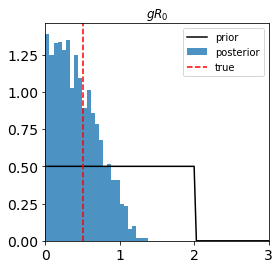

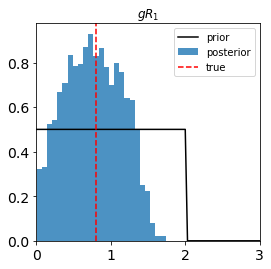

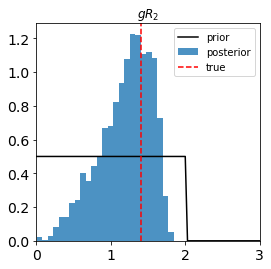

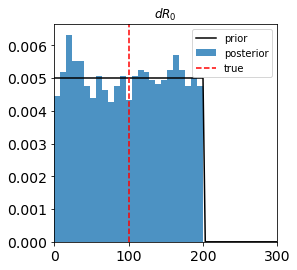

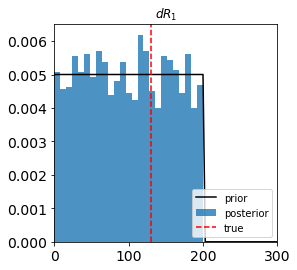

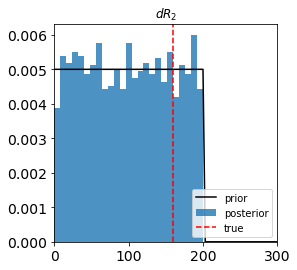

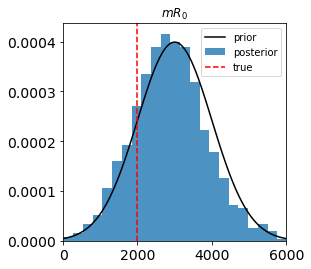

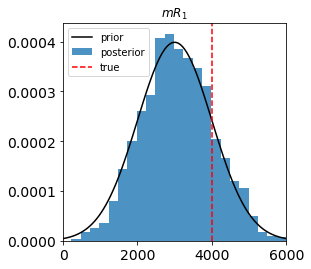

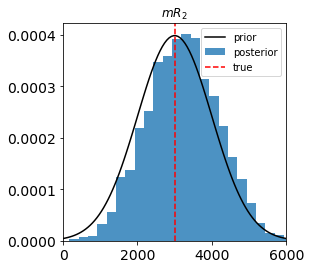

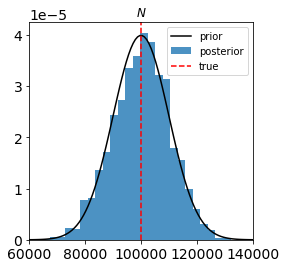

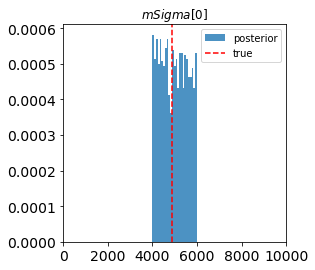

true: 		 ['gR_0' 'gR_1' 'gR_2']
posterior: 	 ['gR_0' 'gR_1' 'gR_2'] 

true: 		 ['dR_0' 'dR_1' 'dR_2']
posterior: 	 ['dR_1' 'dR_0' 'dR_2'] 

true: 		 ['mR_0' 'mR_2' 'mR_1']
posterior: 	 ['mR_0' 'mR_1' 'mR_2'] 



In [22]:
if dataset == 'logistic':

    gR_mean_posterior, dR_mean_posterior, mR_mean_posterior = [], [], []

    posterior_dist = history_abund.get_distribution(m=0, t=history_abund.max_t)[0]

    for par in logistic_parameter_names:

        par_posterior = posterior_dist.loc[:,par]

        x = np.linspace(logistic_limits_dict[par][0], logistic_limits_dict[par][1], 100)

        if par in gR_names: 
            gR_mean_posterior.append(np.mean(par_posterior))
            mp.plot(x, sp.stats.uniform.pdf(x, logistic_priors_dict[par][1], logistic_priors_dict[par][2]), color='k', label = 'prior')

        if par in dR_names: 
            dR_mean_posterior.append(np.mean(par_posterior))
            mp.plot(x, sp.stats.uniform.pdf(x, logistic_priors_dict[par][1], logistic_priors_dict[par][2]), color='k', label = 'prior')

        if par in mR_names: 
            mR_mean_posterior.append(np.mean(par_posterior))
            mp.plot(x, sp.stats.norm.pdf(x, logistic_priors_dict[par][1], logistic_priors_dict[par][2]), color='k', label = 'prior')

        if par == 'N': 
            mp.plot(x, sp.stats.norm.pdf(x, logistic_priors_dict[par][1], logistic_priors_dict[par][2]), color='k', label = 'prior')

        mp.hist(par_posterior, density=True, bins = 25, alpha=0.8, label = 'posterior')
        mp.axvline(true_par[par], linestyle='--', color = 'r', label = 'true')
        mp.xlim(logistic_limits_dict[par])
        mp.legend()
        mp.title(r'$%s$'%par)
        mp.show()

    print('true: \t\t', np.array(gR_names)[np.argsort(gR)])
    print('posterior: \t', np.array(gR_names)[np.argsort(gR_mean_posterior)],'\n')

    print('true: \t\t', np.array(dR_names)[np.argsort(dR)])
    print('posterior: \t', np.array(dR_names)[np.argsort(dR_mean_posterior)],'\n')

    print('true: \t\t', np.array(mR_names)[np.argsort(mR)])
    print('posterior: \t', np.array(mR_names)[np.argsort(mR_mean_posterior)],'\n')

Set limits for axes in plots

In [23]:
if dataset == 'LV': 

    gR_lim = n_types * [(0, 3)]
    I_intra_lim = n_types * [(-1.2E-4, 0.2E-4)]
    I_inter_lim = (n_types**2-n_types) * [(-2E-4, 2E-4)]
    mSigma_lim = [(0., 1E5)]

    limits = gR_lim + I_intra_lim + I_inter_lim + mSigma_lim
    LV_limits_dict = dict(zip(LV_parameter_names, limits))

Plotting

In [24]:
if dataset == 'LV': 

    gR_mean_posterior, I_intra_mean_posterior, I_inter_mean_posterior = [], [], []

    posterior_dist = history_abund.get_distribution(m=1, t=history_abund.max_t)[0]

    for par in LV_parameter_names:

        par_posterior = posterior_dist.loc[:,par]

        x = np.linspace(LV_limits_dict[par][0], LV_limits_dict[par][1], 100)

        if par in gR_names: 
            gR_mean_posterior.append(np.mean(par_posterior))
            mp.plot(x, sp.stats.norm.pdf(x, LV_priors_dict[par][1], LV_priors_dict[par][2]), color='k', label = 'prior')

        if par in I_intra_names: 
            I_intra_mean_posterior.append(np.mean(par_posterior))
            mp.plot(x, sp.stats.uniform.pdf(x, LV_priors_dict[par][1], LV_priors_dict[par][2]), color='k', label = 'prior')

        if par in I_inter_names: 
            I_inter_mean_posterior.append(np.mean(par_posterior))
            mp.plot(x, sp.stats.norm.pdf(x, LV_priors_dict[par][1], LV_priors_dict[par][2]), color='k', label = 'prior')

        mp.hist(par_posterior, density=True, bins = 25, alpha=0.8, label = 'posterior')
        mp.axvline(true_par[par], linestyle='--', color = 'r', label = 'true')
        mp.xlim(LV_limits_dict[par])
        mp.legend()
        mp.title('%s'%par)
        mp.show()

    print('true: \t\t', np.array(gR_names)[np.argsort(gR)])
    print('posterior: \t', np.array(gR_names)[np.argsort(gR_mean_posterior)],'\n')

In [25]:
# df, w = history_abund.get_distribution(m=0, t=history_abund.max_t)

# ax = plot_kde_matrix(df, w, limits=logistic_limits_dict, refval=true_par, refval_color='red')
# mp.show();